## Importing DB

Connecting to the DB

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


conn = sqlite3.connect("kickstarter.db")
cursor = conn.cursor()

### Initialization

In [2]:
# Creating Campaign table which is the main table
campaign_table = """
CREATE TABLE IF NOT EXISTS Campaign (
    id INTEGER PRIMARY KEY,
    name TEXT,
    sub_category_id INTEGER,
    country_id INTEGER,
    currency_id INTEGER,
    launched DATETIME,
    deadline DATETIME,
    goal REAL,
    pledged REAL,
    backers INTEGER,
    outcome TEXT,
    FOREIGN KEY (sub_category_id) REFERENCES Sub_category(id),
    FOREIGN KEY (country_id) REFERENCES Country(id),
    FOREIGN KEY (currency_id) REFERENCES Currency(id)
);
"""

# Execute the updated SQL command
cursor.execute(campaign_table)

# Commit the changes and close the connection
conn.commit()
# conn.close()

In [3]:
# Creating Other tables

# Country table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Country (
    id INTEGER PRIMARY KEY,
    name TEXT
);
""")

# Currency table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Currency (
    id INTEGER PRIMARY KEY,
    name TEXT
);
""")

# Category table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Category (
    id INTEGER PRIMARY KEY,
    name TEXT
);
""")

# Sub_category table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Sub_category (
    id INTEGER PRIMARY KEY,
    name TEXT,
    category_id INTEGER,
    FOREIGN KEY (category_id) REFERENCES Category(id)
);
""")

conn.commit()
# conn.close()


In [5]:
import pandas as pd

# List of tables to check
tables = ['Campaign', 'Country', 'Currency', 'Category', 'Sub_category']

# Dictionary to store results
null_counts = {}

for table in tables:
    # Get column names for each table
    cursor.execute(f"PRAGMA table_info({table})")
    columns = [column[1] for column in cursor.fetchall()]
    
    # Check NULL values for each column
    for column in columns:
        query = f"SELECT COUNT(*) FROM {table} WHERE {column} IS NULL"
        cursor.execute(query)
        count = cursor.fetchone()[0]
        
        # Only store if there are NULL values
        if count > 0:
            null_counts[f"{table}.{column}"] = count

# Convert results to DataFrame for better visualization
if null_counts:
    df_nulls = pd.DataFrame.from_dict(null_counts, orient='index', columns=['NULL Count'])
    print("Columns with NULL values:")
    print(df_nulls)
else:
    print("No NULL values in any table.")

No NULL values in any table.


### Preliminary Analysis

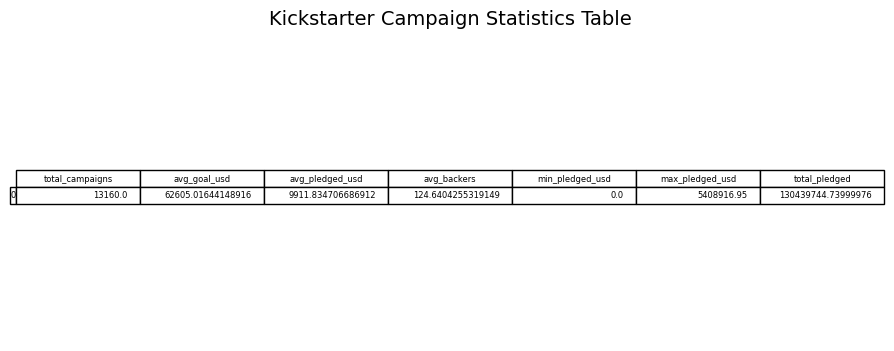

In [2]:
query = """
SELECT 
    COUNT(*) AS total_campaigns,
    AVG(goal_usd) AS avg_goal_usd,
    AVG(pledged_usd) AS avg_pledged_usd,
    AVG(backers) AS avg_backers,
    MIN(pledged_usd) AS min_pledged_usd,
    MAX(pledged_usd) AS max_pledged_usd,
    SUM(pledged_usd) AS total_pledged
FROM Flat_Campaign
WHERE NOT outcome = 'canceled';
"""

# Execute query and load data into DataFrame
stats_df = pd.read_sql_query(query, conn)

# Transpose DataFrame for easier visualization (optional)
stats_transposed = stats_df.T.reset_index()
stats_transposed.columns = ['Metric', 'Value']

# Visualization 2: Table of Statistics
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(8, 4)) 
ax.axis('tight')
ax.axis('off')
table(ax, stats_df, loc='center', colWidths=[0.2]*len(stats_df.columns))
plt.title("Kickstarter Campaign Statistics Table", fontsize=14)
plt.show()